Ingesting Data...
Simulating 10000 seasons...
Sim 0: Wins=39, Final Lev=0.34
Sim 100: Wins=44, Final Lev=0.11
Sim 200: Wins=39, Final Lev=0.22
Sim 300: Wins=34, Final Lev=0.21
Sim 400: Wins=39, Final Lev=0.36
Sim 500: Wins=33, Final Lev=0.30
Sim 600: Wins=46, Final Lev=0.39
Sim 700: Wins=53, Final Lev=0.47
Sim 800: Wins=44, Final Lev=0.26
Sim 900: Wins=37, Final Lev=0.21
Sim 1000: Wins=38, Final Lev=0.34
Sim 1100: Wins=40, Final Lev=0.14
Sim 1200: Wins=37, Final Lev=0.22
Sim 1300: Wins=39, Final Lev=0.33
Sim 1400: Wins=33, Final Lev=0.29
Sim 1500: Wins=45, Final Lev=0.41
Sim 1600: Wins=39, Final Lev=0.34
Sim 1700: Wins=45, Final Lev=0.41
Sim 1800: Wins=38, Final Lev=0.22
Sim 1900: Wins=34, Final Lev=0.29
Sim 2000: Wins=34, Final Lev=0.30
Sim 2100: Wins=44, Final Lev=0.38
Sim 2200: Wins=41, Final Lev=0.14
Sim 2300: Wins=37, Final Lev=0.19
Sim 2400: Wins=45, Final Lev=0.42
Sim 2500: Wins=37, Final Lev=0.21
Sim 2600: Wins=39, Final Lev=0.35
Sim 2700: Wins=43, Final Lev=0.37
Sim 2800: Wins

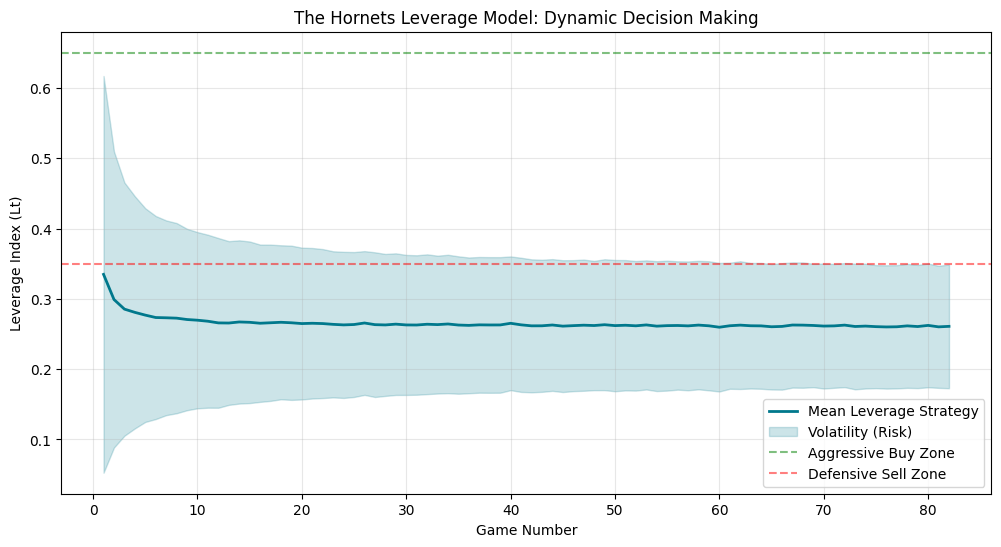

Projected Mean Wins: 38.6


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION & CONSTANTS ---

NUM_SIMULATIONS = 10000  # Adjust to 10000 for final high-res run
GAMES_IN_SEASON = 82
MY_TEAM = 'CHO'         # Charlotte Hornets ID

# Financial Constants (Millions USD)
FINANCIALS = {
    'baseline_revenue': 328,
    'initial_debt': 304,
    'max_debt_capacity': 475,
    'safe_debt_threshold': 325
}

# Model Weights
WEIGHTS = {
    'lev_perf': 5.0,         # Impact of Winning on Leverage
    'lev_fin': 3.0,          # Impact of Money on Leverage
    'lev_risk': -4.0,        # Impact of Risk on Leverage
    'revenue_win_factor': 0.3, 
    'revenue_star_factor': 0.5
}

# --- 2. DATA INGESTION & PREPARATION ---

def initialize_league_data(csv_file_path):
    """
    Parses CSV to build full rosters with Skill, Weight, and Injury Risk.
    """
    df = pd.read_csv(csv_file_path)
    df = df[df['Player'] != 'League Average']

    # A. Consolidate Traded Players
    # Use total stats (2TM) but assign to current team (last stint)
    final_rows = []
    for player, group in df.groupby('Player'):
        if len(group) > 1 and group['Team'].isin(['2TM', '3TM', '4TM']).any():
            stats_row = group[group['Team'].isin(['2TM', '3TM', '4TM'])].iloc[0].copy()
            current_team = group[~group['Team'].isin(['2TM', '3TM', '4TM'])].iloc[-1]['Team']
            stats_row['Team'] = current_team
            final_rows.append(stats_row)
        else:
            final_rows.append(group.iloc[0])
    
    df_clean = pd.DataFrame(final_rows)

    # B. Calculate Metrics
    # MPG (Minutes Per Game)
    df_clean['MPG'] = df_clean['MP'] / df_clean['G']
    
    # Weight: Share of 48-minute game
    df_clean['Weight'] = df_clean['MPG'] / 48.0
    
    # Skill: Normalized PER
    valid_players = df_clean[df_clean['MP'] > 50]
    min_per, max_per = valid_players['PER'].min(), valid_players['PER'].max()
    
    def get_skill(per):
        return (per - min_per) / (max_per - min_per)
    
    # Injury Risk: Baseline 50 games = Healthy
    def get_injury_risk(g):
        return max(0.0, 1.0 - (g / 50.0))

    df_clean['Skill_Norm'] = df_clean['PER'].apply(get_skill)
    df_clean['Injury_Risk'] = df_clean['G'].apply(get_injury_risk)

    # C. Build Roster Dictionary
    # Structure: { 'CHO': [ {player_data}, ... ], 'BOS': [...] }
    all_rosters = {}
    
    for team in df_clean['Team'].unique():
        # Get team roster sorted by importance (Weight)
        roster_df = df_clean[df_clean['Team'] == team].sort_values('Weight', ascending=False)
        
        team_list = []
        for _, row in roster_df.iterrows():
            player = {
                'name': row['Player'],
                'skill': [row['Skill_Norm']],
                'weight': row['Weight'],
                'injury_prob': row['Injury_Risk'],
                'is_star': row['PER'] > 18.0 and row['MPG'] > 25.0
            }
            team_list.append(player)
        
        all_rosters[team] = team_list # Keep full roster, logic will pick rotation

    return all_rosters

# --- 3. HELPER FUNCTIONS ---

def get_game_strength(roster, top_n=10):
    """
    Simulates a single game's roster strength.
    Iterates through top N players. Rolls dice for injury.
    Returns: Weighted Strength Score, Number of Stars Active, Injury Count
    """
    strength_sum = 0
    weight_sum = 0
    stars_active = 0
    starters_injured = 0
    
    # Limit to rotation size (Top 10 players usually play)
    rotation = roster[:top_n]
    
    for i, p in enumerate(rotation):
        # Bernoulli Trial: Is player healthy today?
        is_healthy = np.random.random() > p['injury_prob']
        
        if is_healthy:
            contribution = p['skill'][-1] * p['weight']
            strength_sum += contribution
            weight_sum += p['weight']
            if p['is_star']: stars_active += 1
        else:
            # Count starter injury if it's a key player (Top 5)
            if i < 5: starters_injured += 1
        lower = 0.8 * p['skill'][0]
        upper = 1.2 * p['skill'][0]
        if p['skill'][-1] >= lower and p['skill'][-1] <= upper:
            p['skill'].append(p['skill'][-1] + np.random.uniform(-0.05,0.05))
        else:
            if p['skill'][-1] > upper: p['skill'].append(upper)
            if p['skill'][-1] < lower: p['skill'].append(lower)
            
    # Normalize strength by the total weight of minutes filled
    final_strength = strength_sum / weight_sum if weight_sum > 0 else 0
    return final_strength, stars_active, starters_injured

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# --- 4. MAIN SIMULATION LOOP ---

def run_simulation(csv_path):
    
    # 1. Initialize Data
    print("Ingesting Data...")
    all_rosters = initialize_league_data(csv_path)
    
    # Get list of opponents (All teams except Charlotte)
    opponents = list(all_rosters.keys())
    if MY_TEAM in opponents: opponents.remove(MY_TEAM)
    
    # Storage
    results_leverage = np.zeros((NUM_SIMULATIONS, GAMES_IN_SEASON))
    results_wins = np.zeros(NUM_SIMULATIONS)
    
    print(f"Simulating {NUM_SIMULATIONS} seasons...")
    
    for sim in range(NUM_SIMULATIONS):
        
        # Create Schedule: Random 82 games against league opponents
        schedule = np.random.choice(opponents, GAMES_IN_SEASON)
        
        # Reset State
        wins = 0
        current_rev = FINANCIALS['baseline_revenue']
        current_debt = FINANCIALS['initial_debt']
        
        season_lev = []
        
        for t, opp_team in enumerate(schedule):
            
            # A. Calculate Dynamic Team Strengths
            # 1. My Team (Charlotte)
            my_strength, my_stars, my_injuries = get_game_strength(all_rosters[MY_TEAM])
            
            # 2. Opponent Team (Specific Opponent Roster)
            opp_strength, _, _ = get_game_strength(all_rosters[opp_team])
            
            # B. Determine Outcome (Logistic Regression)
            diff = my_strength - opp_strength
            # Logistic Prob: P(Win) = 1 / (1 + e^-(b0 + b1*diff))
            # b1=15.0 makes the curve steep enough for NBA talent gaps
            # b0=0.087 if home court advantage is considered, .5 probability
            win_prob = 1 / (1 + np.exp(-(0.087*np.random.choice([0,1]) + 15.0 * diff)))
            win_prob += np.random.normal(-0.05, 0.05) # Random Noise
            
            # Simulation (Bernoulli)
            is_win = 1 if np.random.random() < win_prob else 0
            wins += is_win
            
            # C. Update Finance
            game_rev = 0
            if is_win: game_rev += WEIGHTS['revenue_win_factor']
            if my_stars > 0: game_rev += (WEIGHTS['revenue_star_factor'] * my_stars)
            current_rev += game_rev
            
            # D. Calculate Indices
            
            # Performance (Pt): Weighted mix of Record and Current Roster Strength
            win_pct = wins / (t + 1)
            P_t = (0.6 * win_pct) + (0.4 * my_strength)
            
            # Finance (Ft): Debt Capacity
            F_t = 1.0 - (current_debt / FINANCIALS['max_debt_capacity'])
            
            # Risk (Rt): Injury Status + Financial Stress
            injury_risk_score = my_injuries / 5.0 # % of starters out
            debt_risk_score = max(0, (current_debt - FINANCIALS['safe_debt_threshold']) / 200)
            R_t = (0.7 * injury_risk_score) + (0.3 * debt_risk_score)
            R_t = min(1.0, R_t)
            
            # E. Leverage Index (Lt) - The Dependent Variable
            Z = (WEIGHTS['lev_perf'] * P_t) + \
                (WEIGHTS['lev_fin'] * F_t) + \
                (WEIGHTS['lev_risk'] * R_t) - 4.0
            
            L_t = sigmoid(Z)
            season_lev.append(L_t)
            
        results_leverage[sim, :] = season_lev
        results_wins[sim] = wins
        
        if sim % 100 == 0:
            print(f"Sim {sim}: Wins={wins}, Final Lev={L_t:.2f}")

    return results_leverage, results_wins

# --- 5. EXECUTION & PLOTTING ---

"""rosters = initialize_league_data('data/season-stats.csv')
print("Teams sorted by baseline strength:")
team_strengths = {}
for team in rosters.keys():
    strength, stars, injuries = get_game_strength(rosters[team])
    team_strengths[team] = strength
sorted_teams = sorted(team_strengths.items(), key=lambda x: x[1], reverse=True)
for team, strength in sorted_teams:
    print(f"{team}: {strength:.3f}")

win_prob = 1 / (1 + np.exp(-(0 + 15.0 * (sorted_teams[0][1] - sorted_teams[-1][1]))))
print(win_prob)"""

# Make sure 'season-stats.csv' is in your folder
lev_data, win_data = run_simulation('data/season-stats.csv')

# --- PLOTTING CODE (Run after simulation) ---
mean_lev = np.mean(lev_data, axis=0)
std_lev = np.std(lev_data, axis=0)
x = np.arange(1, 83)

plt.figure(figsize=(12, 6))
plt.plot(x, mean_lev, color='#00788C', linewidth=2, label='Mean Leverage Strategy') # Hornets Teal
plt.fill_between(x, mean_lev - std_lev, mean_lev + std_lev, color='#00788C', alpha=0.2, label='Volatility (Risk)')

plt.axhline(0.65, color='green', linestyle='--', alpha=0.5, label='Aggressive Buy Zone')
plt.axhline(0.35, color='red', linestyle='--', alpha=0.5, label='Defensive Sell Zone')

plt.title('The Hornets Leverage Model: Dynamic Decision Making')
plt.xlabel('Game Number')
plt.ylabel('Leverage Index (Lt)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Projected Mean Wins: {np.mean(win_data):.1f}")